First Generation


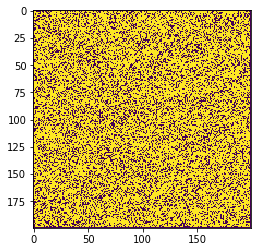

Present Generation = 100


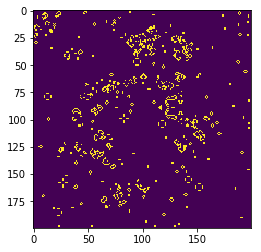

In [11]:
#NOT PARALLEL VERSION
import numpy
import sys
from matplotlib import pyplot as plt

#prob = float(sys.argv[1])
#COLS = int(sys.argv[2])
#ROWS = int(sys.argv[3])
#generations = int(sys.argv[4])
prob = 0.7
COLS = 200
ROWS = 198
generations = 100

N=numpy.random.binomial(1,prob,size=(ROWS+2)*COLS)
M=numpy.reshape(N,(ROWS+2,COLS))

M[0,:] = 0 #entire first row = 0
M[ROWS+1,:] = 0 #add row at end all = 0
M[:,0] = 0 #entire first column = 0
M[:,COLS-1] = 0 #entire last column = 0 

initM = numpy.copy(M)
#print initM
print("First Generation")

plt.imshow(initM, interpolation='nearest')
plt.show()

generation = 0
for i in range(generations):
        generation = generation + 1
         # print ("Generation = ",generation)
        intermediateM = numpy.copy(M) # create new matrix to store new generation 
        for ROWelem in range(1,ROWS+1):
                for COLelem in range(1,COLS-1):
                        sum = ( M[ROWelem-1,COLelem-1]+M[ROWelem-1,COLelem]+M[ROWelem-1,COLelem+1]
                            +M[ROWelem,COLelem-1]+M[ROWelem,COLelem+1]
                            +M[ROWelem+1,COLelem-1]+M[ROWelem+1,COLelem]+M[ROWelem+1,COLelem+1] )
                        # print(ROWelem," ",COLelem," ",sum)
                        if M[ROWelem,COLelem] == 1: # if cell is alive
                                if sum < 2:
                                        intermediateM[ROWelem,COLelem] = 0 # cell < 2 neighbors dies 
                                elif sum > 3:
                                        intermediateM[ROWelem,COLelem] = 0 # cell > 3 neighbors dies 
                                else:
                                        intermediateM[ROWelem,COLelem] = 1 # cell = 2|3 neighbors lives on 
                        if M[ROWelem,COLelem] == 0: # if cell is dead 
                                if sum == 3:
                                        intermediateM[ROWelem,COLelem] = 1 # cell = 3 neighbors becomes alive
                                else:
                                        intermediateM[ROWelem,COLelem] = 0 # cell < 3 < neighbors stays dead
        M = numpy.copy(intermediateM) # copy new generation into original matrix to loop through again
        if numpy.sum(M) == 0:
                print("Extinction Occurs at generation = ",generation)
                plt.imshow(M, interpolation='nearest')
                plt.show()
                break
      #  print(" ")
      #  print M

#print(" ")
#print(" ")
#print("First Generation")
#print initM

#print(" ")
print("Present Generation = %d" %(generation))
#print M
plt.imshow(M, interpolation='nearest')
plt.show()

In [ ]:
#PARALLEL VERSION 

from mpi4py import MPI
import numpy
import matplotlib.animation as animation
from matplotlib import pyplot as plt

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
stat = MPI.Status()

fig = plt.figure()

prob = 0.7
COLS = 200
ROWS = 200
generations = 100

if size > ROWS:
        print("Not enough ROWS")
        exit()

#Get number of rows for each subGRID
subROWS=ROWS//size+2 #Divide total rows by number of workers and add 2 ghost rows to each workers portion
#Create subGrid
grid = numpy.random.binomial(1,prob,size=subROWS*COLS) #result of each cell having 70% prob=1/alive
subGrid = numpy.reshape(grid,(subROWS,COLS))

#BC for all ranks
subGrid[:,0] = 0
subGrid[:,COLS-1] = 0
#BC for rank 0
if rank == 0:
    subGrid[0,:] = 0
#BC for last rank
if rank == size-1:
    subGrid[subROWS-1,:] = 0

#FUNCTION DEFINITIONS 
def msgUp(subGrid):
    # Sends and Recvs rows with Rank+1
        comm.send(subGrid[subROWS-2,:],dest=rank+1)
        subGrid[subROWS-1,:]=comm.recv(source=rank+1)
        return 0
    
def msgDn(subGrid):
    # Sends and Recvs rows with Rank-1
        comm.send(subGrid[1,:],dest=rank-1)
        subGrid[0,:] = comm.recv(source=rank-1)
        return 0

def computeGridPoints(subGrid):
    for ROWelem in range(1,subROWS-1):
        for COLelem in range(1,COLS-1):
            sum = (subGrid[ROWelem-1,COLelem-1]+subGrid[ROWelem-1,COLelem]+subGrid[ROWelem-1,COLelem+1]
                                    +subGrid[ROWelem,COLelem-1]+subGrid[ROWelem,COLelem+1]
                                    +subGrid[ROWelem+1,COLelem-1]+subGrid[ROWelem+1,COLelem]+subGrid[ROWelem+1,COLelem+1])
            if subGrid[ROWelem,COLelem] == 1: # if cell is alive
                if sum < 2:
                    tempGrid[ROWelem,COLelem] = 0 # cell < 2 neighbors dies 
                elif sum > 3:
                    tempGrid[ROWelem,COLelem] = 0 # cell > 3 neighbors dies 
                else:
                    tempGrid[ROWelem,COLelem] = 1 # cell = 2|3 neighbors lives on 
            if subGrid[ROWelem,COLelem] == 0: # if cell is dead 
                if sum == 3:
                    tempGrid[ROWelem,COLelem] = 1 # cell = 3 neighbors becomes alive
                else:
                    tempGrid[ROWelem,COLelem] = 0 # cell < 3 < neighbors stays dead
    return 0

#oldGrid=comm.gather(subGrid[1:subROWS-1,:],root=0)
#print(oldGrid)

#CALCULATION
generation = 0
ims=[]
for i in range(generations):
    generation = generation + 1
    tempGrid = numpy.copy(subGrid) # create new matrix to store new generation 
    computeGridPoints(subGrid)
    #exchange edge row info
    if rank == 0:
        msgUp(subGrid)
    elif rank == size-1:
        msgDn(subGrid)
    else:
        msgUp(subGrid)
        msgDn(subGrid)

    # copy new generation into original matrix to loop through again
    subGrid = numpy.copy(tempGrid) 
    finalGrid = comm.gather(subGrid[1:subROWS-1,:],root=0)
    result= numpy.vstack(finalGrid)
    im=plt.imshow(result, animated=True,interpolation='None')
    ims.append([im])
    if numpy.sum(subGrid) == 0:
        break #Extinction occurs

print("Present Generation = %d" %(generation))
ani = animation.ArtistAnimation(fig, ims, interval=25, blit=True,repeat_delay=500)
ani.save('animate_life.mp4')

plt.show()